In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra
import os
import zipfile

In [8]:
local_zip = '800Hz_48000HzSampFreq.zip'
unzipped_folder = local_zip.replace(".zip", "")
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(unzipped_folder)
zip_ref.close()

In [9]:
input_stimuli = os.listdir(unzipped_folder)[2]
path = os.path.join(unzipped_folder, input_stimuli)

# specify signal source
fs, signal = wavfile.read(path)

/Users/anaconda3/envs/pyroom/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


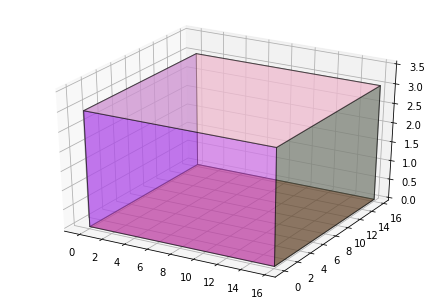

In [10]:
#specify room dimention
width = 16. #16 meters
depth = 16.
height = 3.

ab = 0.1 #absorption of the walls
mo = 40 #maximum number of reflections allowed in the ISM

#make room
room = pra.ShoeBox([width, depth, height], fs=fs, absorption=ab, max_order=mo)

fig, ax = room.plot(img_order=3)
ax.set_xlim([-1, width + .5])
ax.set_ylim([-1, depth + .5]);
ax.set_zlim([0, height + .5]);

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


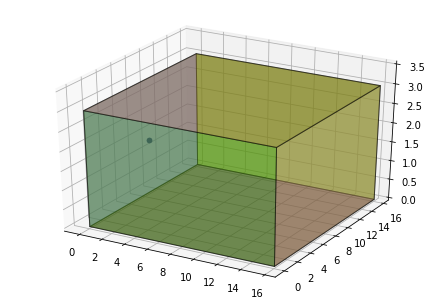

In [11]:
x = 0.5
y = depth/2
z = height/2

# add source to 3D room
room.add_source([x, y, z], signal=signal)

fig, ax = room.plot()
ax.set_xlim([-1, width + .5])
ax.set_ylim([-1, depth + .5]);
ax.set_zlim([0, height + .5]);

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


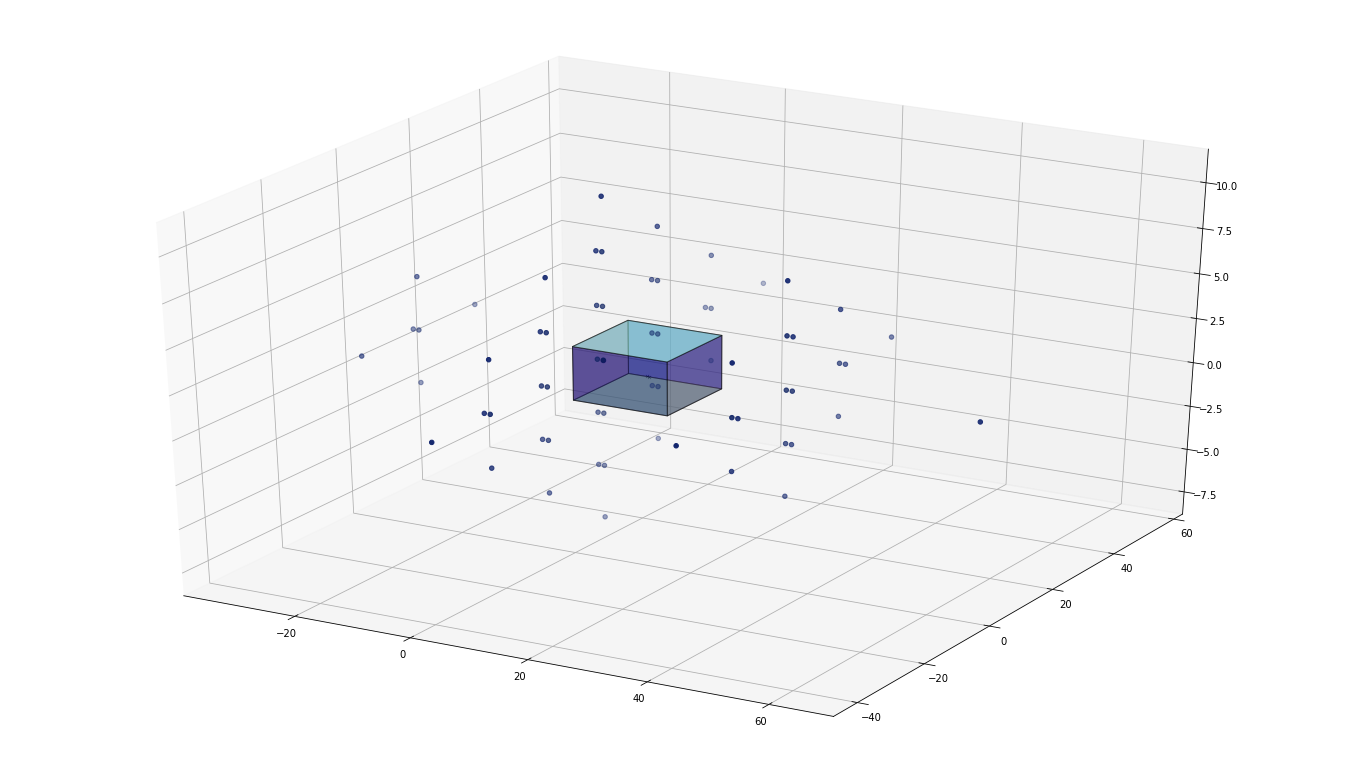

In [12]:
# add two-microphone array
R = np.array([[8., 8.3], [8., 8.], [1.,  1.]])  # [[x], [y], [z]]
mic_array = pra.MicrophoneArray(R, room.fs)
room.add_microphone_array(mic_array)

# compute image sources
room.image_source_model(use_libroom=True)

# visualize 3D polyhedron room and image sources
fig, ax = room.plot(img_order=3)
fig.set_size_inches(18.5, 10.5)


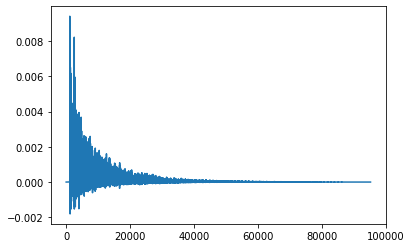

In [13]:
room.compute_rir()

# plot the RIR between mic 1 and source 0
import matplotlib.pyplot as plt
plt.plot(room.rir[1][0])
plt.show()

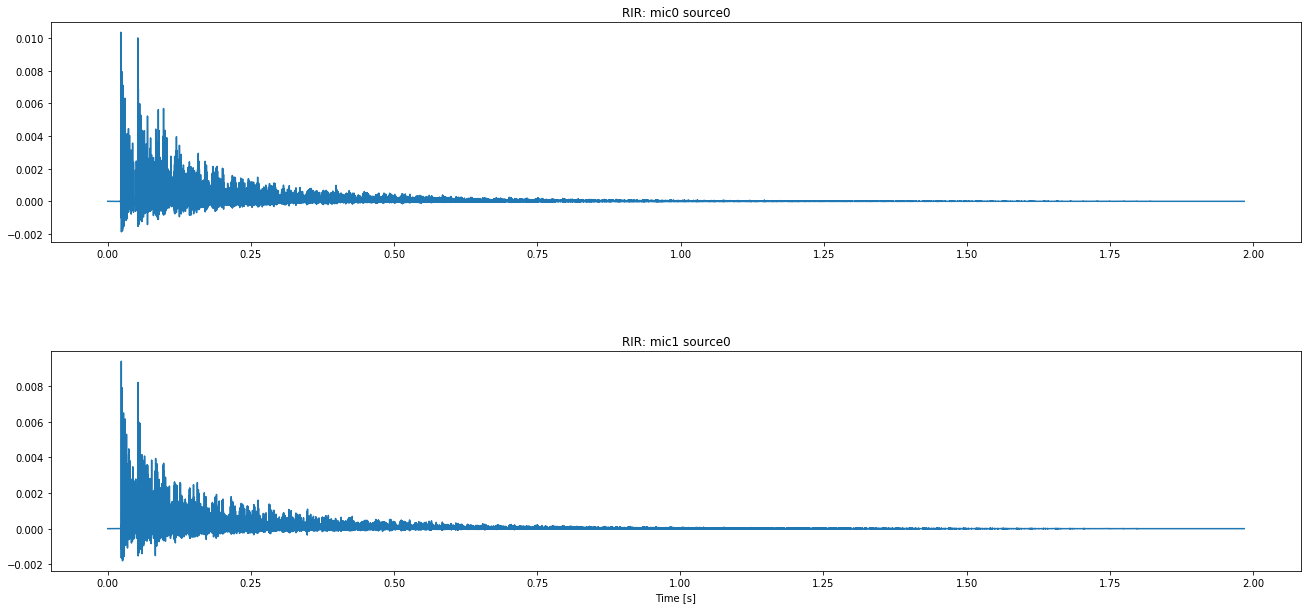

In [14]:
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20, 10)

In [15]:
room.simulate()
print(room.mic_array.signals.shape)

(2, 133670)


In [16]:
print("Original WAV:")
IPython.display.Audio(signal, rate=room.fs)

Original WAV:


In [17]:
print("Simulated propagation to first mic:")
IPython.display.Audio(room.mic_array.signals[0,:], rate=room.fs)

Simulated propagation to first mic:


In [18]:
print("Simulated propagation to second mic:")
IPython.display.Audio(room.mic_array.signals[1,:], rate=room.fs)

Simulated propagation to second mic:


In [19]:
print("Simulated propagation to both mic:")
IPython.display.Audio(room.mic_array.signals, rate=room.fs)

Simulated propagation to both mic:


# Run the following cell to generate stimuli in fixed room size

In [38]:
fixed_dir = os.path.join('output', 'fixed')

if not os.path.isdir(fixed_dir):
    os.makedirs(fixed_dir)

room_dimention = np.array([16., 16., 3.]) #[width, depth, height]

source_positions_x = np.array([4., 8., 12.])
mic_positions = np.divide(room_dimention, 2)
    
for x in source_positions_x:
    x_dir = os.path.join(fixed_dir, str(x))
    if not os.path.isdir(x_dir):
        os.makedirs(x_dir)
        
    source_position = np.divide(room_dimention, 2) #center of room
    source_position[0] = x
    
    for input_stimuli in os.listdir(unzipped_folder):
        #loop over each stimuli file in specified folder
        path = os.path.join(unzipped_folder, input_stimuli)

        # specify signal source
        fs, signal = wavfile.read(path)

        #make room
        room = pra.ShoeBox(room_dimention, fs=fs, absorption=ab, max_order=mo)

        #add microphones
        
        R = np.array([np.repeat(mic_positions[i], 2) for i in range(len(mic_positions))])  # [[x], [y], [z]]
        mic_array = pra.MicrophoneArray(R, room.fs)
        room.add_microphone_array(mic_array)

        # add source to 3D room
        room.add_source(source_position, signal=signal)

        #simulate
        room.simulate()

        #output wavfile
        room.mic_array.to_wav(os.path.join(x_dir, input_stimuli))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


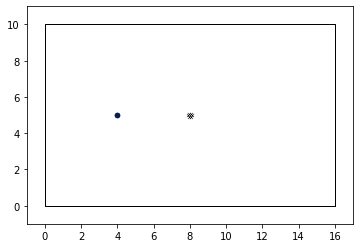

In [33]:
corners = np.array([[0,0], [0, 10], [16, 10], [16, 0]]).T  # [x,y]
room = pra.Room.from_corners(corners)


room.add_source([4.,5.], signal=signal)

R = pra.circular_2D_array(center=[8., 5.], M=6, phi0=0, radius=0.1)
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

#room.add_source([4.,8.], signal=signal)
fig, ax = room.plot()
ax.set_xlim([-1, 17])
ax.set_ylim([-1, 11]);


In [29]:
room_dimention = [16., 16., 3.] #[width, depth, height]
mic_positions = np.divide(room_dimention, 2)
np.repeat(mic_positions[0], 2)

array([8., 8.])

In [60]:
varying_dir = os.path.join('output', 'varying')

if not os.path.isdir(varying_dir):
    os.makedirs(varying_dir)

    
room_floor_sizes = np.array([4., 8., 12.])
room_dimentions = np.array([[size, size, 3] for size in room_floor_sizes])

mic_positions = np.array([room / 2 for room in room_dimentions]) #center of room

source_positions = mic_positions
source_positions[:,0] = 0.1 #shift x position to vary left of the room

for width, mic, source in zip(room_dimentions, mic_positions, source_positions):
    width_dir = os.path.join(varying_dir, str(width[0]))
    if not os.path.isdir(width_dir):
        os.makedirs(width_dir)
        
    for input_stimuli in os.listdir(unzipped_folder):
        #loop over each stimuli file in specified folder
        path = os.path.join(unzipped_folder, input_stimuli)

        # specify signal source
        fs, signal = wavfile.read(path)

        #make room
        room = pra.ShoeBox(width, fs=fs, absorption=ab, max_order=mo)

        #add microphones
        R = np.array([np.repeat(mic_positions[i], 2) for i in range(len(mic_positions))])  # [[x], [y], [z]]
        mic_array = pra.MicrophoneArray(R, room.fs)
        room.add_microphone_array(mic_array)

        # add source to 3D room
        room.add_source(source, signal=signal)

        #simulate
        room.simulate()

        #output wavfile
        room.mic_array.to_wav(os.path.join(width_dir, input_stimuli))